![title](images/bluescreen.jpg)

# Movie Genre Profitability for Microsoft

**Author:** Nicholas Gigliotti
***

## Overview

A one-paragraph overview of the project, including the business problem, data, methods, results and recommendations.

## Business Problem
​
Microsoft has decided to enter the movie business and make original films. They want to know what kinds of movies are currently profitable, and they want concrete, actionable, insights.

1. What genres have the strongest correlation with return on investment?
2. Are low-budget or high-budget films more profitable?

Summary of the business problem you are trying to solve, and the data questions that you plan to answer to solve them.

***
Questions to consider:
* What are the business's pain points related to this project?
* How did you pick the data analysis question(s) that you did?
* Why are these questions important from a business perspective?
***

## Data Understanding

I use data from two sources in my analysis: [The Numbers](https://www.the-numbers.com/movie/budgets "The Numbers") and the [Internet Movie Database](https://www.imdb.com/interfaces/ "Internet Movie Database") (IMDb). IMDb is an expansive and easily accessible source of movie data which, most importantly, includes genre labels for thousands of films. IMDb lacks financial data, however, so I am forced to rely on The Numbers for that information.

***
Questions to consider:
* Where did the data come from, and how do they relate to the data analysis questions?
* What do the data represent? Who is in the sample and what variables are included?
* What is the target variable?
* What are the properties of the variables you intend to use?
***

In [15]:
import os
# import re
# import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns

import utils
import cleaning
import plotting

%matplotlib inline
sns.set(font_scale=1.25)
pd.options.display.float_format = '{:,.2f}'.format

### The Numbers
My financial data comes from a website called "The Numbers" which has a healthy collection of production budget and revenue data. The Numbers is owned by Nash Information Services, a movie industry research and consulting firm. The most important columns for my analysis are `production_budget`, `domestic_gross`, and `worldwide_gross`. I use these columns later to calculate profit and return on investment (ROI).

The table includes a little under 6,000 observations.

In [16]:
tn = pd.read_csv(os.path.join('zippedData', 'tn.movie_budgets.csv.gz'),
                 parse_dates=['release_date'])
tn

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,2009-12-18,Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,2011-05-20,Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,2019-06-07,Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,2015-05-01,Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,2017-12-15,Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"
...,...,...,...,...,...,...
5777,78,2018-12-31,Red 11,"$7,000",$0,$0
5778,79,1999-04-02,Following,"$6,000","$48,482","$240,495"
5779,80,2005-07-13,Return to the Land of Wonders,"$5,000","$1,338","$1,338"
5780,81,2015-09-29,A Plague So Pleasant,"$1,400",$0,$0


### Internet Movie Database
My genre data comes from IMDb, a subsidiary of Amazon which is a well known source of movie information. Naturally, the most important column for my analysis will be `genres`. I later use this column to compute Pearson correlations between genres and different financial statistics.

This table is much larger than `tn`, with a little over 146,000 observations.

In [17]:
imdb = pd.read_csv(os.path.join('zippedData', 'imdb.title.basics.csv.gz'))
imdb

,tconst,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.00,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.00,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.00,Drama
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,nan,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.00,"Comedy,Drama,Fantasy"
...,...,...,...,...,...,...
146139,tt9916538,Kuambil Lagi Hatiku,Kuambil Lagi Hatiku,2019,123.00,Drama
146140,tt9916622,Rodolpho Teóphilo - O Legado de um Pioneiro,Rodolpho Teóphilo - O Legado de um Pioneiro,2015,nan,Documentary
146141,tt9916706,Dankyavar Danka,Dankyavar Danka,2013,nan,Comedy
146142,tt9916730,6 Gunn,6 Gunn,2017,116.00,NaN


## Data Preparation

Describe and justify the process for preparing the data for analysis.

***
Questions to consider:
* Were there variables you dropped or created?
* How did you address missing values or outliers?
* Why are these choices appropriate given the data and the business problem?
***

### The Numbers
I start by replacing the incorrect `id` column with a column of genuinely unique ID numbers. I also create a `release_year` column, because it will come in handy later when merging tables.

In [18]:
del tn['id']
tn.insert(0, 'tn_id', np.arange(tn.shape[0]) + 1)
tn.insert(2, 'release_year', tn['release_date'].dt.year)
tn.head()

,tn_id,release_date,release_year,movie,production_budget,domestic_gross,worldwide_gross
0,1,2009-12-18,2009,Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,2011-05-20,2011,Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,2019-06-07,2019,Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,2015-05-01,2015,Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,2017-12-15,2017,Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


The columns `production_budget`, `domestic gross`, and `worldwide gross` are in string format, so I remove the extraneous symbols and convert them to `np.float64`.

In [19]:
money_cols = ['production_budget', 'domestic_gross', 'worldwide_gross']
tn[money_cols] = (tn.loc[:, money_cols]
                    .apply(cleaning.process_strings)
                    .apply(lambda x: x.astype('float64')))
tn.sort_values('worldwide_gross').head()

,tn_id,release_date,release_year,movie,production_budget,domestic_gross,worldwide_gross
5037,5038,2019-04-23,2019,Living Dark: The Story of Ted the Caver,"1,750,000.00",0.00,0.00
3975,3976,2015-05-15,2015,Pound of Flesh,"7,500,000.00",0.00,0.00
4627,4628,2011-06-28,2011,2:13,"3,500,000.00",0.00,0.00
4628,4629,2013-01-29,2013,"Batman: The Dark Knight Returns, Part 2","3,500,000.00",0.00,0.00
3947,3948,2019-06-21,2019,Burn Your Maps,"8,000,000.00",0.00,0.00


These 0 values for `domestic_gross` and `worldwide_gross` look very suspicious. Some of these 0s are for Netflix original productions such as *Bright* and *The Ridiculous 6*. Obviously those should not be counted as massive commercial failures simply because they were not released in theaters. Other 0s are for movies like *PLAYMOBIL*, which other sources report as generating revenue. Still other 0s are for movies which were released only domestically or only abroad.

In [20]:
tn.query('(domestic_gross == 0) & (worldwide_gross == 0)').head()

,tn_id,release_date,release_year,movie,production_budget,domestic_gross,worldwide_gross
194,195,2020-12-31,2020,Moonfall,"150,000,000.00",0.00,0.00
479,480,2017-12-13,2017,Bright,"90,000,000.00",0.00,0.00
480,481,2019-12-31,2019,Army of the Dead,"90,000,000.00",0.00,0.00
535,536,2020-02-21,2020,Call of the Wild,"82,000,000.00",0.00,0.00
670,671,2019-08-30,2019,PLAYMOBIL,"75,000,000.00",0.00,0.00


I remove any rows where the domestic or worldwide gross is 0, since nearly every 0 is a null value or error.

In [21]:
tn = tn.loc[tn.query('(domestic_gross > 0) & (worldwide_gross > 0)').index]
tn.sort_values('worldwide_gross').head()

,tn_id,release_date,release_year,movie,production_budget,domestic_gross,worldwide_gross
5770,5771,2008-08-14,2008,The Rise and Fall of Miss Thang,"10,000.00",401.00,401.00
5518,5519,2005-10-13,2005,The Dark Hours,"400,000.00",423.00,423.00
5769,5770,1996-04-01,1996,Bang,"10,000.00",527.00,527.00
5466,5467,2018-05-11,2018,Higher Power,"500,000.00",528.00,528.00
5027,5028,1993-01-01,1993,Ed and his Dead Mother,"1,800,000.00",673.00,673.00


Looks like the data extends back in time much farther than I want.

Text(0.5, 0, 'Year')

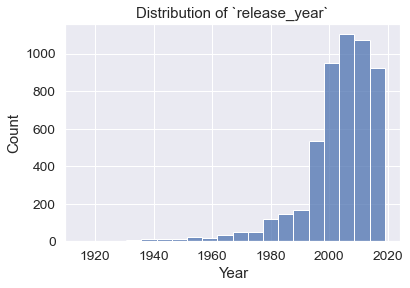

In [22]:
ax = sns.histplot(data=tn, x='release_year', bins=20)
ax.set_title('Distribution of `release_year`')
ax.set_xlabel('Year')

I drop everything earlier than 2009 because I'm only interested in data that's relevant to current box office performance. 2020 was a particularly bad year because of the COVID-19 pandemic, so I leave that out as well.

In [23]:
tn = tn.loc[tn.query('(release_year <= 2019) & (release_year >= 2009)').index]
tn.sort_values('release_date').head()

,tn_id,release_date,release_year,movie,production_budget,domestic_gross,worldwide_gross
2934,2935,2009-01-09,2009,The Unborn,"16,000,000.00","42,670,410.00","78,208,812.00"
4318,4319,2009-01-09,2009,Not Easily Broken,"5,000,000.00","10,572,742.00","10,732,909.00"
1880,1881,2009-01-09,2009,Bride Wars,"30,000,000.00","58,715,510.00","115,150,424.00"
1164,1165,2009-01-16,2009,Defiance,"50,000,000.00","28,644,813.00","52,987,754.00"
2736,2737,2009-01-16,2009,Notorious,"19,000,000.00","36,843,682.00","44,972,183.00"


Looks like all of the basic money distributions are very right-skewed, which is not surprising. I expect there to be many more small films than big films, financially-speaking.

array([<AxesSubplot:title={'center':'Distribution of `production_budget`'}, xlabel='Dollars', ylabel='Count'>,
       <AxesSubplot:title={'center':'Distribution of `domestic_gross`'}, xlabel='Dollars', ylabel='Count'>,
       <AxesSubplot:title={'center':'Distribution of `worldwide_gross`'}, xlabel='Dollars', ylabel='Count'>],
      dtype=object)

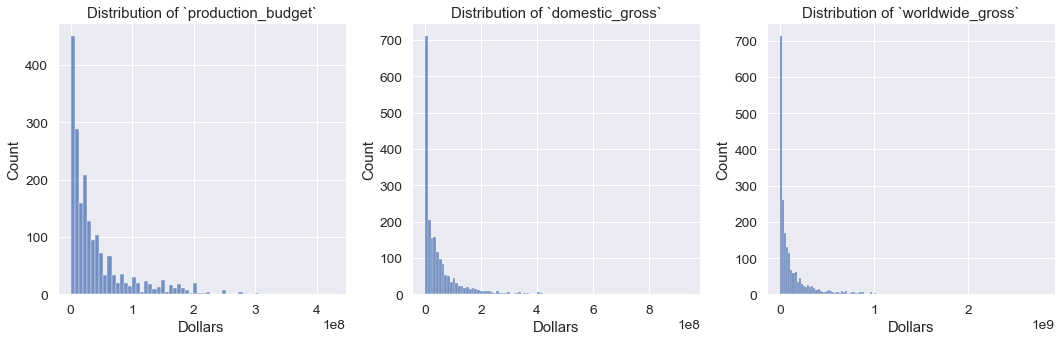

In [24]:
plotting.multi_hist(tn, include=money_cols, xlabel='Dollars')

These box plots indicate that there are many extreme values in the dataset. The data points beyond the upper whiskers are not truly outliers in this case. *Avatar* really does have a worldwide gross of 2.8 billion dollars. There is not a good scientific reason to altar or remove these values.

Text(0, 0.5, 'Dollars (billions)')

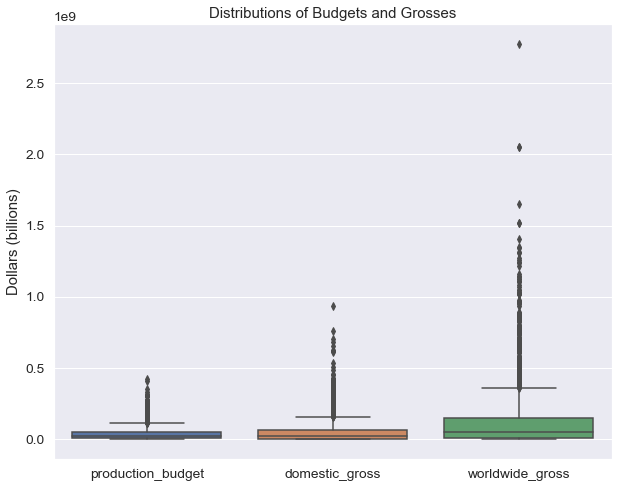

In [25]:
fix, ax = plt.subplots(figsize=(10,8))
ax = sns.boxplot(data=tn[money_cols], ax=ax)
ax.set_title('Distributions of Budgets and Grosses')
ax.set_ylabel('Dollars (billions)')

#### Financial Calculations
I calculate domestic and worldwide **profit** by subtracting `production_budget` from each respective gross column.

In [26]:
tn['worldwide_profit'] = tn.eval('worldwide_gross - production_budget')
tn['domestic_profit'] = tn.eval('domestic_gross - production_budget')
money_cols += ['worldwide_profit', 'domestic_profit']
tn.sort_values('worldwide_profit', ascending=False).head()

,tn_id,release_date,release_year,movie,production_budget,domestic_gross,worldwide_gross,worldwide_profit,domestic_profit
0,1,2009-12-18,2009,Avatar,"425,000,000.00","760,507,625.00","2,776,345,279.00","2,351,345,279.00","335,507,625.00"
6,7,2018-04-27,2018,Avengers: Infinity War,"300,000,000.00","678,815,482.00","2,048,134,200.00","1,748,134,200.00","378,815,482.00"
5,6,2015-12-18,2015,Star Wars Ep. VII: The Force Awakens,"306,000,000.00","936,662,225.00","2,053,311,220.00","1,747,311,220.00","630,662,225.00"
33,34,2015-06-12,2015,Jurassic World,"215,000,000.00","652,270,625.00","1,648,854,864.00","1,433,854,864.00","437,270,625.00"
66,67,2015-04-03,2015,Furious 7,"190,000,000.00","353,007,020.00","1,518,722,794.00","1,328,722,794.00","163,007,020.00"


The distribution of `domestic_profit` is almost symmetrical around 0, although it is still right-skewed overall. The distribution of `worldwide_profit` is even more right-skewed. In both distributions the positive skew indicates that there are more winners than losers. This is unsurprising, since production companies strive to generate profit.

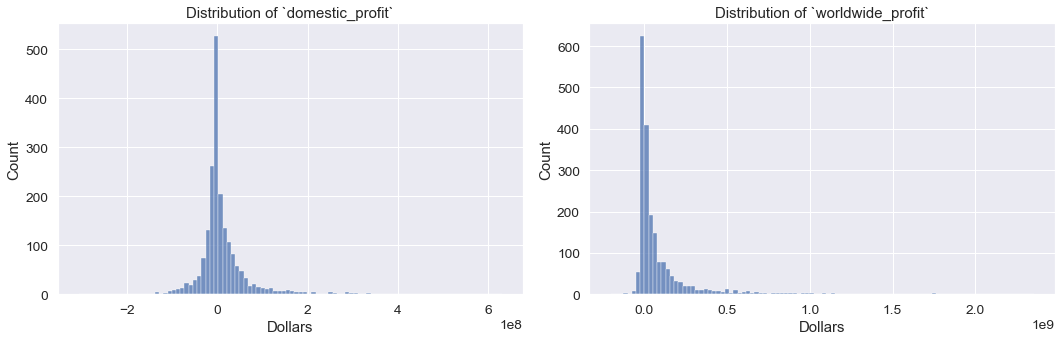

In [27]:
ax = plotting.multi_hist(tn, include=['domestic_profit', 'worldwide_profit'],
                            xlabel='Dollars', bins=100)

I calculate the percent **return on investment (ROI)** by dividing profit by budget and multiplying by 100. The sorted result is... ominous...

In [28]:
tn['worldwide_roi'] = tn.eval('(worldwide_profit / production_budget) * 100')
tn['domestic_roi'] = tn.eval('(domestic_profit / production_budget) * 100')
money_cols += ['worldwide_roi', 'domestic_roi']
tn.sort_values('worldwide_roi', ascending=False).head()

,tn_id,release_date,release_year,movie,production_budget,domestic_gross,worldwide_gross,worldwide_profit,domestic_profit,worldwide_roi,domestic_roi
5492,5493,2009-09-25,2009,Paranormal Activity,"450,000.00","107,918,810.00","194,183,034.00","193,733,034.00","107,468,810.00","43,051.79","23,881.96"
5679,5680,2015-07-10,2015,The Gallows,"100,000.00","22,764,410.00","41,656,474.00","41,556,474.00","22,664,410.00","41,556.47","22,664.41"
5211,5212,2012-01-06,2012,The Devil Inside,"1,000,000.00","53,262,945.00","101,759,490.00","100,759,490.00","52,262,945.00","10,075.95","5,226.29"
5459,5460,2009-04-23,2009,Home,"500,000.00","15,433.00","44,793,168.00","44,293,168.00","-484,567.00","8,858.63",-96.91
5062,5063,2011-04-01,2011,Insidious,"1,500,000.00","54,009,150.00","99,870,886.00","98,370,886.00","52,509,150.00","6,558.06","3,500.61"


The following is a box plot of `domestic_roi` and `worldwide_roi` plotted on a logarithmic scale. Interestingly, `domestic_roi` is heavily clustered under 100%, whereas the upper quartile of `worldwide_roi` is much higher. This is probably because production companies focus on the worldwide market nowadays.

There are a number of extreme values beyond the upper whiskers, but as you can see in the previous cell, these are just extremely successful horror movies. There is not a good scientific reason to altar or remove these data points.

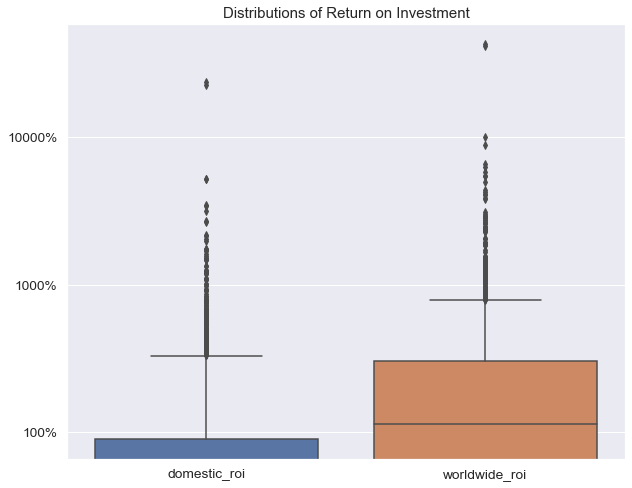

In [30]:
fix, ax = plt.subplots(figsize=(10,8))
ax = sns.boxplot(data=tn[['domestic_roi', 'worldwide_roi']], ax=ax)
ax.set_title('Distributions of Return on Investment')
ax.set_ylabel(None)
ax.set_yscale('log')
ax.yaxis.set_major_formatter(ticker.PercentFormatter())

In [15]:
cleaning.info(tn)

,dup,dup_%,nan,nan_%
tn_id,0,0.00,0,0.00
release_date,1329,66.72,0,0.00
release_year,1981,99.45,0,0.00
movie,4,0.20,0,0.00
production_budget,1687,84.69,0,0.00
domestic_gross,0,0.00,0,0.00
worldwide_gross,0,0.00,0,0.00
worldwide_profit,0,0.00,0,0.00
domestic_profit,0,0.00,0,0.00
worldwide_roi,1,0.05,0,0.00


In [16]:
tn[tn[['movie']].duplicated(keep=False)]

,tn_id,release_date,release_year,movie,production_budget,domestic_gross,worldwide_gross,worldwide_profit,domestic_profit,worldwide_roi,domestic_roi
38,39,2010-05-14,2010,Robin Hood,"210,000,000.00","105,487,148.00","322,459,006.00","112,459,006.00","-104,512,852.00",53.55,-49.77
243,244,2015-03-27,2015,Home,"130,000,000.00","177,397,510.00","385,997,896.00","255,997,896.00","47,397,510.00",196.92,36.46
408,409,2018-11-21,2018,Robin Hood,"99,000,000.00","30,824,628.00","84,747,441.00","-14,252,559.00","-68,175,372.00",-14.40,-68.86
2140,2141,2009-12-04,2009,Brothers,"26,000,000.00","28,544,157.00","45,043,870.00","19,043,870.00","2,544,157.00",73.25,9.79
3307,3308,2015-08-14,2015,Brothers,"13,000,000.00","656,688.00","17,856,688.00","4,856,688.00","-12,343,312.00",37.36,-94.95
5009,5010,2010-04-09,2010,The Square,"1,900,000.00","406,216.00","740,932.00","-1,159,068.00","-1,493,784.00",-61.00,-78.62
5099,5100,2013-10-25,2013,The Square,"1,500,000.00","124,244.00","176,262.00","-1,323,738.00","-1,375,756.00",-88.25,-91.72
5459,5460,2009-04-23,2009,Home,"500,000.00","15,433.00","44,793,168.00","44,293,168.00","-484,567.00","8,858.63",-96.91


In [17]:
tn.to_json(os.path.join('precomputed', 'tn.profit.json'))

### Internet Movie Database

In [19]:
cleaning.info(imdb)

,dup,dup_%,nan,nan_%
runtime_minutes,145776,99.75,31739,21.72
genres,145058,99.26,5408,3.70
original_title,8370,5.73,21,0.01
tconst,0,0.00,0,0.00
primary_title,10073,6.89,0,0.00
start_year,146125,99.99,0,0.00


In [20]:
imdb[imdb[['primary_title', 'original_title', 'start_year']].duplicated(keep=False)].sort_values('primary_title')

,tconst,primary_title,original_title,start_year,runtime_minutes,genres
103890,tt6085916,(aguirre),(aguirre),2016,97.00,"Biography,Documentary"
106201,tt6214664,(aguirre),(aguirre),2016,98.00,"Biography,Comedy,Documentary"
129962,tt8032828,100 Milioni di bracciate,100 Milioni di bracciate,2017,nan,Biography
129979,tt8034014,100 Milioni di bracciate,100 Milioni di bracciate,2017,nan,Biography
20394,tt1855110,180,180,2011,121.00,"Drama,Romance"
...,...,...,...,...,...,...
66990,tt3815124,Ângelo de Sousa - Tudo o Que Sou Capaz,Ângelo de Sousa - Tudo o Que Sou Capaz,2010,60.00,"Biography,Documentary"
66992,tt3815128,Ângelo de Sousa - Tudo o Que Sou Capaz,Ângelo de Sousa - Tudo o Que Sou Capaz,2010,60.00,"Biography,Documentary"
66995,tt3815134,Ângelo de Sousa - Tudo o Que Sou Capaz,Ângelo de Sousa - Tudo o Que Sou Capaz,2010,60.00,"Biography,Documentary"
92592,tt5352034,Çagrilan,Çagrilan,2016,85.00,Horror


In [21]:
imdb.drop_duplicates(subset=['primary_title', 'original_title', 'start_year'], inplace=True)

In [22]:
imdb['clean_title'] = cleaning.process_strings(imdb.loc[:, 'primary_title'])
tn = tn.assign(clean_title=cleaning.process_strings(tn['movie']))

In [23]:
imdb = pd.merge(imdb, tn, how='inner', left_on=['start_year', 'clean_title'], right_on=['release_year', 'clean_title'])
imdb.head()

,tconst,primary_title,original_title,start_year,runtime_minutes,genres,clean_title,tn_id,release_date,release_year,movie,production_budget,domestic_gross,worldwide_gross,worldwide_profit,domestic_profit,worldwide_roi,domestic_roi
0,tt0359950,The Secret Life of Walter Mitty,The Secret Life of Walter Mitty,2013,114.00,"Adventure,Comedy,Drama",the secret life of walter mitty,437,2013-12-25,2013,The Secret Life of Walter Mitty,"91,000,000.00","58,236,838.00","187,861,183.00","96,861,183.00","-32,763,162.00",106.44,-36.00
1,tt0365907,A Walk Among the Tombstones,A Walk Among the Tombstones,2014,114.00,"Action,Crime,Drama",a walk among the tombstones,2067,2014-09-19,2014,A Walk Among the Tombstones,"28,000,000.00","26,017,685.00","62,108,587.00","34,108,587.00","-1,982,315.00",121.82,-7.08
2,tt0369610,Jurassic World,Jurassic World,2015,124.00,"Action,Adventure,Sci-Fi",jurassic world,34,2015-06-12,2015,Jurassic World,"215,000,000.00","652,270,625.00","1,648,854,864.00","1,433,854,864.00","437,270,625.00",666.91,203.38
3,tt0376136,The Rum Diary,The Rum Diary,2011,119.00,"Comedy,Drama",the rum diary,1316,2011-10-28,2011,The Rum Diary,"45,000,000.00","13,109,815.00","21,544,732.00","-23,455,268.00","-31,890,185.00",-52.12,-70.87
4,tt0383010,The Three Stooges,The Three Stooges,2012,92.00,"Comedy,Family",the three stooges,1904,2012-04-13,2012,The Three Stooges,"30,000,000.00","44,338,224.00","54,052,249.00","24,052,249.00","14,338,224.00",80.17,47.79


In [24]:
imdb.describe()

,start_year,runtime_minutes,tn_id,release_year,production_budget,domestic_gross,worldwide_gross,worldwide_profit,domestic_profit,worldwide_roi,domestic_roi
count,"1,387.00","1,382.00","1,387.00","1,387.00","1,387.00","1,387.00","1,387.00","1,387.00","1,387.00","1,387.00","1,387.00"
mean,"2,013.87",108.88,"2,261.98","2,013.87","49,170,161.97","63,002,751.12","157,041,689.35","107,871,527.38","13,832,589.15",303.13,103.75
std,2.64,17.81,"1,599.70",2.64,"57,315,551.90","87,082,401.19","240,381,400.91","199,137,721.99","62,360,937.65","1,246.46",681.89
min,"2,010.00",4.00,2.00,"2,010.00","27,000.00",388.00,528.00,"-200,237,650.00","-307,237,650.00",-99.89,-100.00
25%,"2,012.00",96.00,834.50,"2,012.00","10,000,000.00","8,466,155.50","17,856,688.00","886,290.50","-11,829,721.50",10.30,-52.95
50%,"2,014.00",106.00,"2,054.00","2,014.00","28,000,000.00","34,912,982.00","65,532,491.00","33,359,310.00","811,417.00",137.04,4.18
75%,"2,016.00",118.75,"3,554.50","2,016.00","61,500,000.00","77,811,725.50","178,630,456.00","121,178,670.50","26,912,662.00",321.64,111.36
max,"2,019.00",180.00,"5,745.00","2,019.00","410,600,000.00","700,059,566.00","2,048,134,200.00","1,748,134,200.00","500,059,566.00","41,556.47","22,664.41"


In [25]:
imdb.drop(columns=['start_year', 'release_year', 'clean_title', 'movie', 'original_title', 'runtime_minutes'], inplace=True)

In [26]:
cleaning.info(imdb)

,dup,dup_%,nan,nan_%
tconst,0,0.00,0,0.00
primary_title,14,1.01,0,0.00
genres,1171,84.43,0,0.00
tn_id,14,1.01,0,0.00
release_date,820,59.12,0,0.00
production_budget,1146,82.62,0,0.00
domestic_gross,14,1.01,0,0.00
worldwide_gross,14,1.01,0,0.00
worldwide_profit,14,1.01,0,0.00
domestic_profit,14,1.01,0,0.00


In [27]:
imdb['genres'] = imdb.loc[:, 'genres'].str.split(',')
imdb[['genres']]

,genres
0,"[Adventure, Comedy, Drama]"
1,"[Action, Crime, Drama]"
2,"[Action, Adventure, Sci-Fi]"
3,"[Comedy, Drama]"
4,"[Comedy, Family]"
...,...
1382,"[Horror, Thriller]"
1383,"[Crime, Drama, Thriller]"
1384,"[Drama, Horror, Mystery]"
1385,[Documentary]


In [28]:
imdb.explode('genres')['genres'].value_counts()

Drama          671
Comedy         488
Action         421
Adventure      345
Thriller       235
Crime          214
Romance        183
Horror         150
Sci-Fi         129
Biography      129
Fantasy        120
Mystery        115
Animation      100
Family          87
Music           50
History         39
Documentary     35
Sport           32
War             17
Western         10
Musical          9
Name: genres, dtype: int64

In [29]:
# Collapse Music and Musical
imdb.explode('genres').query('genres == "Music"').head()

,tconst,primary_title,genres,tn_id,release_date,production_budget,domestic_gross,worldwide_gross,worldwide_profit,domestic_profit,worldwide_roi,domestic_roi
30,tt0475290,"Hail, Caesar!",Music,2422,2016-02-05,"22,000,000.00","30,080,225.00","64,160,680.00","42,160,680.00","8,080,225.00",191.64,36.73
128,tt1017451,The Runaways,Music,3757,2010-03-19,"9,500,000.00","3,573,673.00","5,278,632.00","-4,221,368.00","-5,926,327.00",-44.44,-62.38
152,tt1068242,Footloose,Music,2339,2011-10-14,"24,000,000.00","51,802,742.00","62,989,834.00","38,989,834.00","27,802,742.00",162.46,115.84
170,tt1126591,Burlesque,Music,1024,2010-11-24,"55,000,000.00","39,440,655.00","90,552,675.00","35,552,675.00","-15,559,345.00",64.64,-28.29
195,tt1193631,Step Up 3D,Music,1909,2010-08-06,"30,000,000.00","42,400,223.00","165,889,117.00","135,889,117.00","12,400,223.00",452.96,41.33


In [30]:
imdb['genres'] = utils.map_list_likes(imdb['genres'], lambda x: 'Musical' if x == 'Music' else x)
imdb.explode('genres')['genres'].value_counts()

Drama          671
Comedy         488
Action         421
Adventure      345
Thriller       235
Crime          214
Romance        183
Horror         150
Biography      129
Sci-Fi         129
Fantasy        120
Mystery        115
Animation      100
Family          87
Musical         59
History         39
Documentary     35
Sport           32
War             17
Western         10
Name: genres, dtype: int64

Text(0, 0.5, 'Genre')

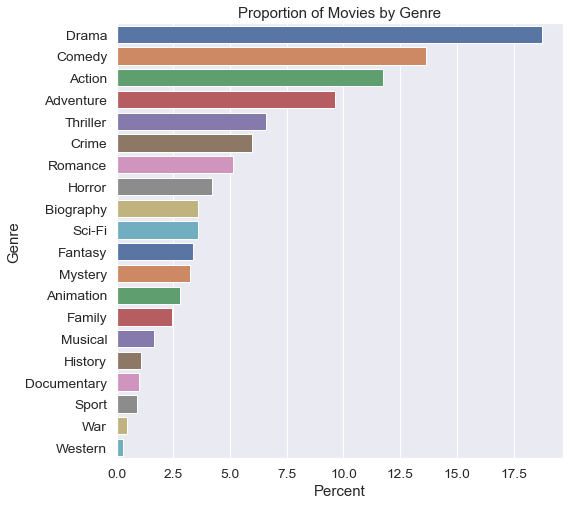

In [31]:
genre_counts = imdb.explode('genres')['genres'].value_counts(normalize=True) * 100
fig, ax = plt.subplots(figsize=(8, 8))
ax = sns.barplot(x=genre_counts.values, y=genre_counts.index, ax=ax, palette='deep')
ax.set_title('Proportion of Movies by Genre')
ax.set_xlabel('Percent')
ax.set_ylabel('Genre')

In [32]:
imdb.to_json(os.path.join('cleanData', 'imdb.tn.basics.json'))

 
## Data Modeling
Describe and justify the process for analyzing or modeling the data.
​
***
Questions to consider:
* How did you analyze or model the data?
* How did you iterate on your initial approach to make it better?
* Why are these choices appropriate given the data and the business problem?
***

In [33]:
combos = pd.crosstab(imdb.explode('genres')['tconst'], imdb.explode('genres')['genres'])
combos = combos.sort_index(axis=1).sort_index(axis=0)
combos.to_json(os.path.join('precomputed', 'genre_combos.json'))
combos.head()

genres,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,Fantasy,History,Horror,Musical,Mystery,Romance,Sci-Fi,Sport,Thriller,War,Western
tconst,,,,,,,,,,,,,,,,,,,,
tt0359950,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
tt0365907,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
tt0369610,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
tt0376136,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
tt0383010,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [34]:
imdb.set_index('tconst', inplace=True)

<AxesSubplot:title={'center':'Genre Correlation with Worldwide Profit'}, xlabel='Correlation', ylabel='Genre'>

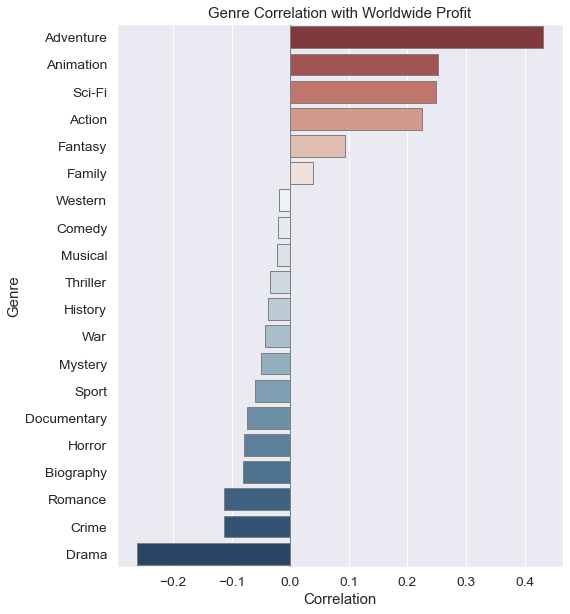

In [35]:
plotting.cat_correlation(combos, imdb['worldwide_profit'], 'Genre Correlation with Worldwide Profit', 'Genre')

Text(0.5, 0, 'Dollars (billions)')

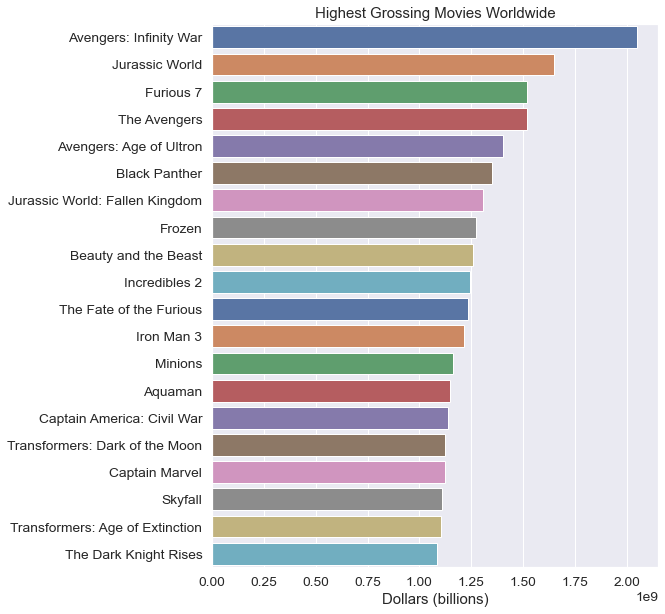

In [49]:
ax = plotting.topn_ranking(imdb, 'primary_title', 'worldwide_gross', 20, figsize=(8, 10))
ax.set_title('Highest Grossing Movies Worldwide')
ax.set_ylabel(None)
ax.set_xlabel('Dollars (billions)')

It's hard to understand intuitively how genre could have anything approaching a linear relationship with profit. What does that even mean? It doesn't help to think about `combos`, the table of truth values created earlier. How could binary truth values have a linear relationship with profit, even in principle?

It all makes very good sense once you look at the following violin plots. The blobs indicate the location and cluster-density of the points in the distribution.

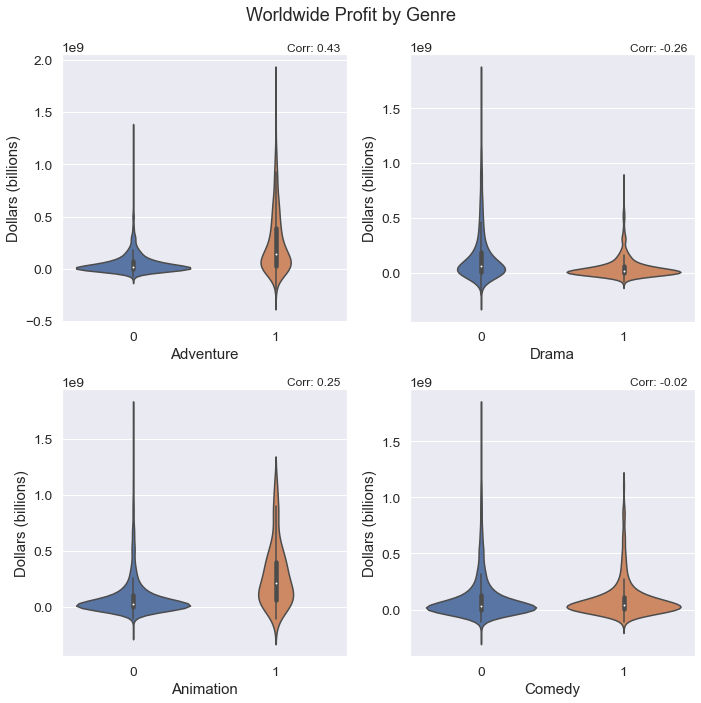

In [36]:
axes = plotting.boolean_violinplots(combos, imdb['worldwide_profit'], suptitle='Worldwide Profit by Genre', include=['Adventure', 'Drama', 'Animation', 'Comedy'], ylabel='Dollars (billions)', size=3, figsize=(10, 10))

<AxesSubplot:title={'center':'Genre Correlation with Worldwide ROI'}, xlabel='Correlation', ylabel='Genre'>

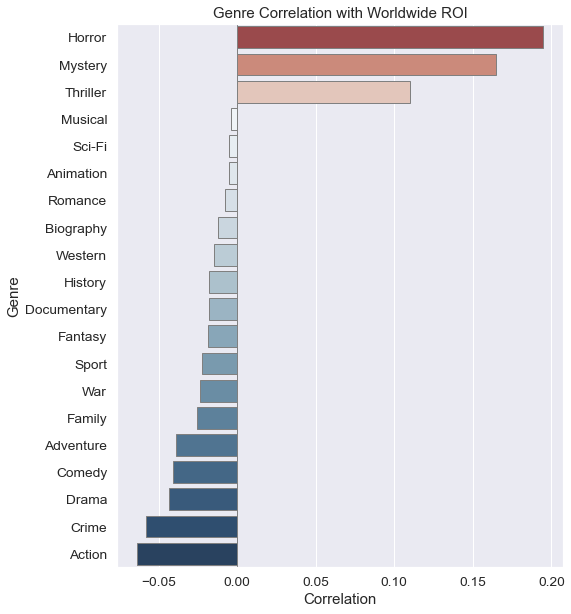

In [37]:
plotting.cat_correlation(combos, imdb['worldwide_roi'], 'Genre Correlation with Worldwide ROI', 'Genre')

Text(0, 0.5, '')

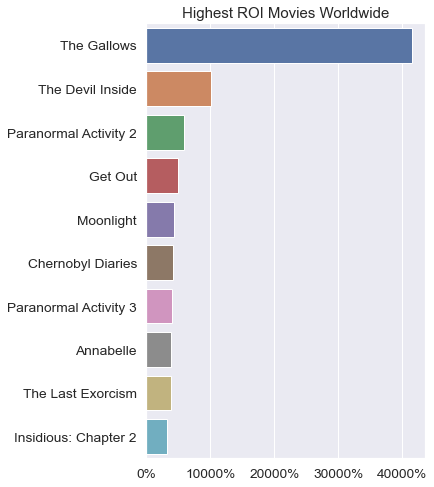

In [42]:
ax = plotting.topn_ranking(imdb, 'primary_title', 'worldwide_roi', 10, figsize=(5, 8))
ax.xaxis.set_major_formatter(ticker.PercentFormatter())
ax.set_title('Highest ROI Movies Worldwide')
ax.set_xlabel(None)
ax.set_ylabel(None)

In [38]:
quartile_labels = ['Low Budget', 'Mid-Low Budget', 'Mid-High Budget', 'High Budget']
imdb['budget_quartile'] = pd.qcut(imdb['production_budget'], 4, quartile_labels)
quartile_intervals = pd.qcut(imdb['production_budget'], 4).dtype.categories
global_roi_by_budget = combos.groupby(imdb['budget_quartile']).corrwith(imdb['worldwide_roi'])
global_roi_by_budget

genres,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,Fantasy,History,Horror,Musical,Mystery,Romance,Sci-Fi,Sport,Thriller,War,Western
budget_quartile,,,,,,,,,,,,,,,,,,,,
Low Budget,-0.05,-0.04,-0.02,-0.03,-0.08,-0.06,-0.05,-0.12,-0.04,0.00,-0.03,0.25,-0.04,0.23,-0.04,-0.01,-0.03,0.18,-0.03,-0.02
Mid-Low Budget,-0.11,-0.04,-0.01,0.05,0.04,-0.13,0.00,0.02,0.00,-0.01,0.01,0.10,0.03,0.04,0.02,0.04,-0.05,0.05,-0.08,-0.04
Mid-High Budget,-0.02,-0.04,-0.02,-0.02,-0.03,-0.12,-0.05,-0.04,-0.04,-0.06,-0.01,0.02,0.16,0.03,0.11,0.04,-0.01,0.10,-0.06,0.02
High Budget,-0.15,0.15,0.25,0.01,0.14,-0.07,-0.02,-0.12,-0.03,-0.07,-0.02,-0.10,0.09,-0.02,-0.11,0.09,-0.05,-0.05,-0.03,-0.03


array([<AxesSubplot:title={'center':'Low Budget\n\\$27,000 to \\$10,000,000'}, xlabel='Correlation', ylabel='Genre'>,
       <AxesSubplot:title={'center':'High Budget\n\\$61,500,000 to \\$410,600,000'}, xlabel='Correlation', ylabel='Genre'>],
      dtype=object)

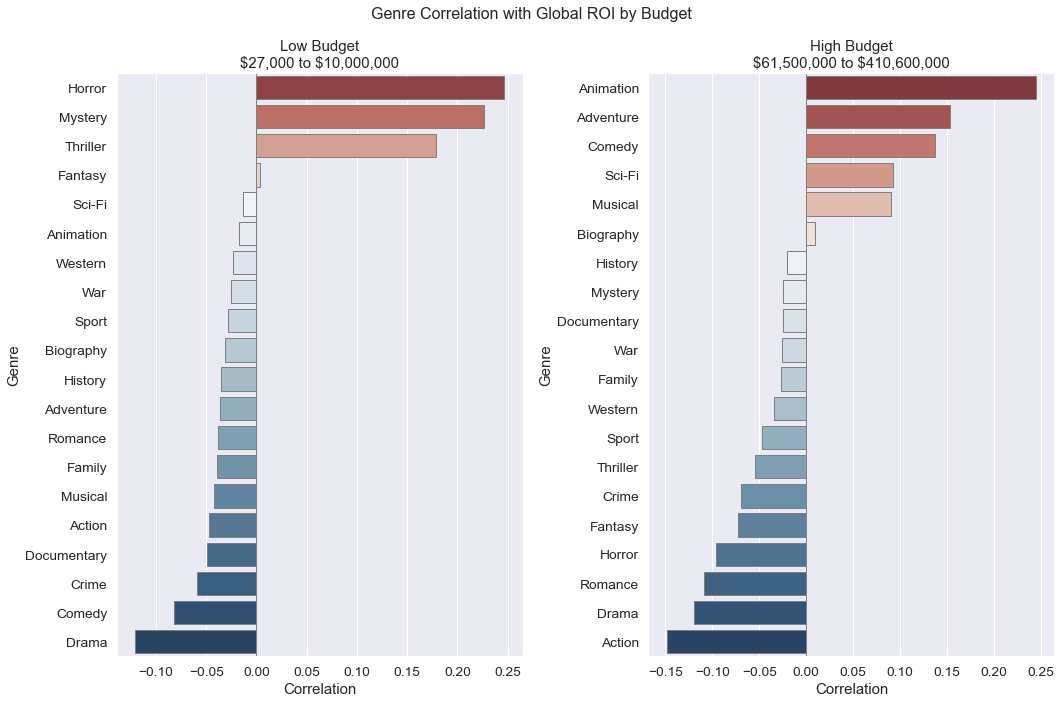

In [39]:
plotting.cat_corr_by_bins(global_roi_by_budget, 
                            'Low Budget', 
                            'High Budget', 
                            quartile_intervals[0], 
                            quartile_intervals[3], 
                            'Genre Correlation with Global ROI by Budget')

array([<AxesSubplot:title={'center':'Mid-Low Budget\n\\$10,000,000 to \\$28,000,000'}, xlabel='Correlation', ylabel='Genre'>,
       <AxesSubplot:title={'center':'Mid-High Budget\n\\$28,000,000 to \\$61,500,000'}, xlabel='Correlation', ylabel='Genre'>],
      dtype=object)

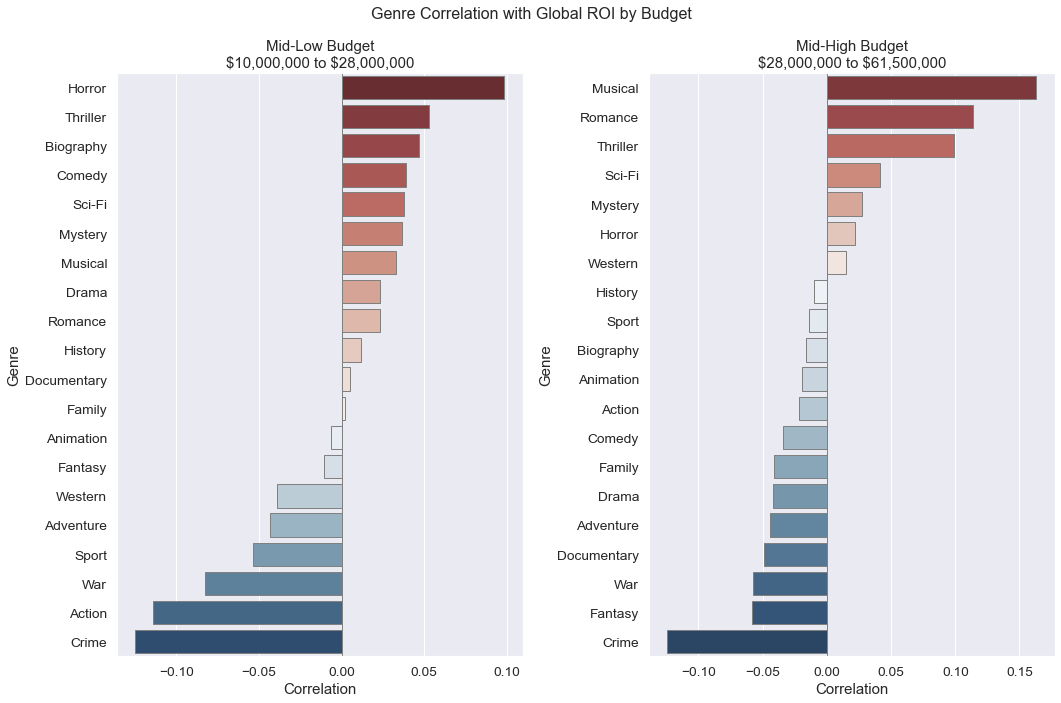

In [40]:
plotting.cat_corr_by_bins(global_roi_by_budget,
                            'Mid-Low Budget', 
                            'Mid-High Budget', 
                            quartile_intervals[1], 
                            quartile_intervals[2], 
                            'Genre Correlation with Global ROI by Budget')

In [41]:
domestic_roi_by_budget = combos.groupby(imdb['budget_quartile']).corrwith(imdb['domestic_roi'])
domestic_roi_by_budget

genres,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,Fantasy,History,Horror,Musical,Mystery,Romance,Sci-Fi,Sport,Thriller,War,Western
budget_quartile,,,,,,,,,,,,,,,,,,,,
Low Budget,-0.06,-0.04,-0.02,-0.04,-0.07,-0.06,-0.04,-0.12,-0.03,0.01,-0.04,0.24,-0.05,0.21,-0.03,-0.01,-0.03,0.16,-0.03,-0.02
Mid-Low Budget,-0.12,-0.01,0.01,0.04,0.09,-0.12,0.03,-0.04,0.08,-0.03,0.01,0.08,0.03,-0.01,0.04,0.04,-0.03,0.00,-0.10,-0.05
Mid-High Budget,-0.09,-0.07,-0.03,0.02,0.08,-0.07,-0.06,-0.05,0.00,-0.08,-0.05,-0.02,0.13,-0.03,0.10,-0.03,0.04,0.02,-0.06,0.05
High Budget,-0.18,0.07,0.22,0.05,0.19,-0.08,-0.05,-0.08,-0.00,-0.10,0.03,-0.11,0.11,-0.00,-0.08,0.08,-0.01,-0.10,-0.01,-0.02


array([<AxesSubplot:title={'center':'Low Budget\n\\$27,000 to \\$10,000,000'}, xlabel='Correlation', ylabel='Genre'>,
       <AxesSubplot:title={'center':'High Budget\n\\$61,500,000 to \\$410,600,000'}, xlabel='Correlation', ylabel='Genre'>],
      dtype=object)

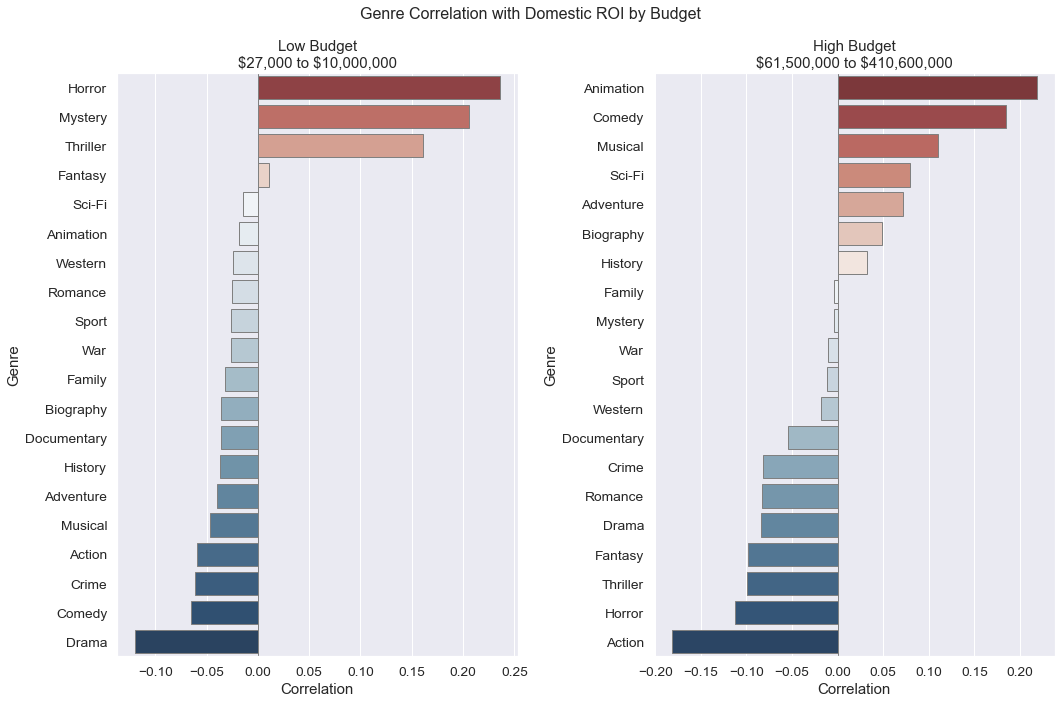

In [42]:
plotting.cat_corr_by_bins(domestic_roi_by_budget, 
                            'Low Budget', 
                            'High Budget', 
                            quartile_intervals[0], 
                            quartile_intervals[3], 
                            'Genre Correlation with Domestic ROI by Budget')

array([<AxesSubplot:title={'center':'Mid-Low Budget\n\\$10,000,000 to \\$28,000,000'}, xlabel='Correlation', ylabel='Genre'>,
       <AxesSubplot:title={'center':'Mid-High Budget\n\\$28,000,000 to \\$61,500,000'}, xlabel='Correlation', ylabel='Genre'>],
      dtype=object)

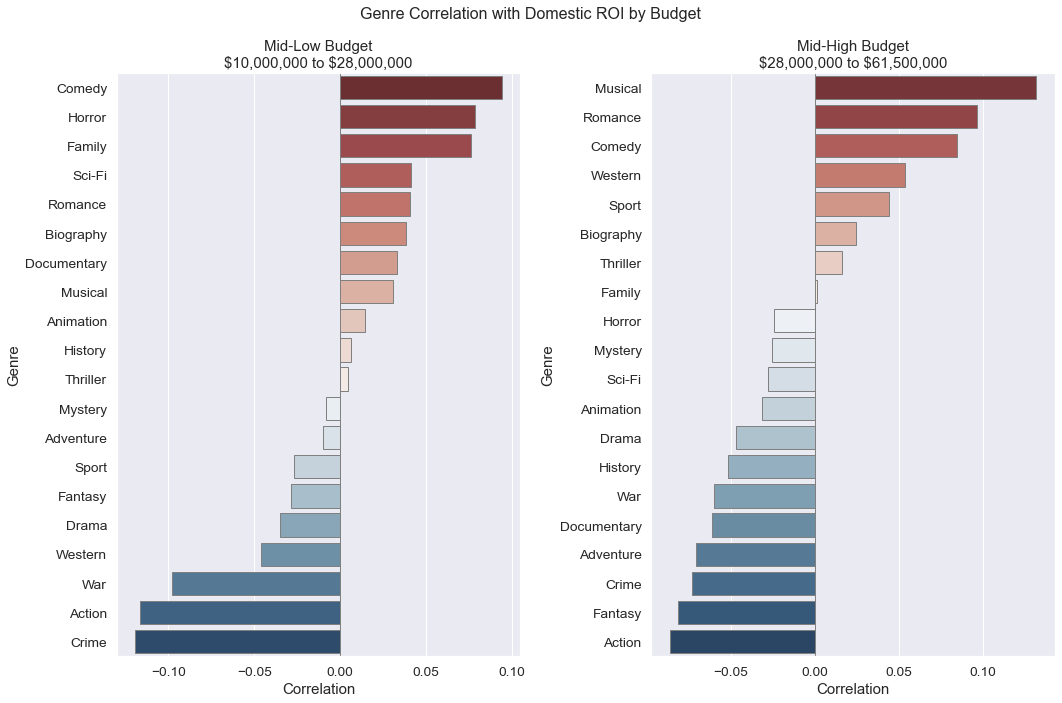

In [106]:
plotting.cat_corr_by_bins(domestic_roi_by_budget,
                            'Mid-Low Budget', 
                            'Mid-High Budget', 
                            quartile_intervals[1], 
                            quartile_intervals[2], 
                            'Genre Correlation with Domestic ROI by Budget')

Text(0.5, 1.0, 'Distribution of Movies: Budget vs. Worldwide ROI')

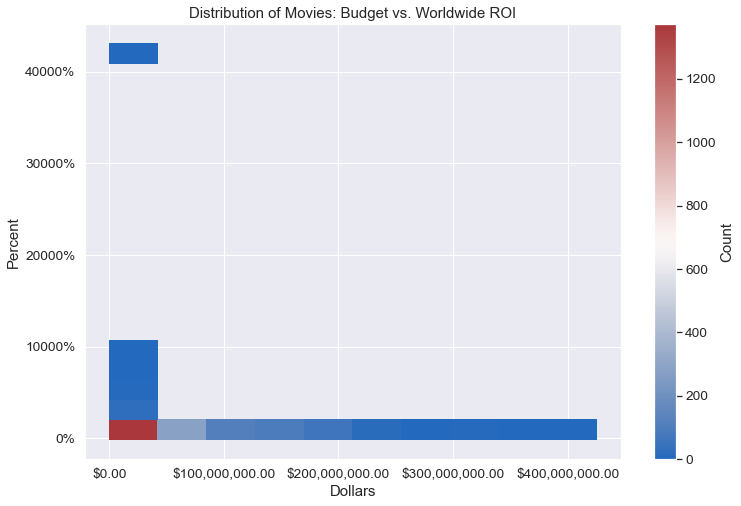

In [71]:

fig, ax = plt.subplots(figsize=(12,8))
cmap = sns.color_palette('vlag', as_cmap=True)
ax = sns.histplot(data=tn, x='production_budget', y='worldwide_roi', ax=ax, bins=(10, 20), stat='count', cbar=True, cmap=cmap, cbar_kws={'label': 'Count'})
ax.yaxis.set_major_formatter(ticker.PercentFormatter())
ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('${x:,.2f}'))
ax.set_xlabel('Dollars')
ax.set_ylabel('Percent')
ax.set_title('Distribution of Movies: Budget vs. Worldwide ROI')

## Evaluation
Evaluate how well your work solves the stated business problem.

***
Questions to consider:
* How do you interpret the results?
* How well does your model fit your data? How much better is this than your baseline model?
* How confident are you that your results would generalize beyond the data you have?
* How confident are you that this model would benefit the business if put into use?
***

## Conclusions
Provide your conclusions about the work you've done, including any limitations or next steps.

***
Questions to consider:
* What would you recommend the business do as a result of this work?
* What are some reasons why your analysis might not fully solve the business problem?
* What else could you do in the future to improve this project?
***